# Introduction to Natural Language Processing (1) 

## Lab03

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import datasets as ds
import torch
import torch.nn as nn
import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(str(parent_dir))

from scripts import data
from scripts import features
from scripts.logistic_regression.model import LogisticRegression
from scripts.logistic_regression import lr_methods, scikit_learn_lr

/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


## Features (6 points)

For every given text, we want to generate a vector with the features seen in class.

**(6 points)** Code the following features:
* 1 if "no" appears in the document, 0 otherwise.
* The count of first and second pronouns in the document.
* 1 if "!" is in the document, 0 otherwise.
* Log(word count in the document).
* Number of words in the document which are in the positive lexicon.
* Number of words in the document which are in the negative lexicon.
* **\[Bonus\]** Add another feature of your choice.

For positive and negative lexicons, you can use the resources provided by [VADER sentiment](https://github.com/cjhutto/vaderSentiment). Look for the `vader_lexicon.txt` file and consider positive word if they score above a certain threshold (for example 1) and negative word if they score below a certain threshold (for example -1). Feel free to use another lexicon if you find one, but make sure you document your choice.


### Tips

* Don't forget to use a similar pre-treatment as the one you used for the previous lab.
* Beware that words in the VADER dictionary are not lemmatized or stemmed. Do not use these pretreatments here.
* When checking for occurences of "no" or pronouns, split the text into token. Just using `"no" in text` would return true if the word "notable" is in your text.


### Loading datasets

In [2]:
splits = ds.get_dataset_split_names('imdb')
train_ds, test_ds = data.load_datasets(splits=splits[:2])

Found cached dataset imdb (/Users/francois.soulier/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Found cached dataset imdb (/Users/francois.soulier/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


### Features extraction

Import lexicon

In [3]:
nltk.download('vader_lexicon')
sid: SentimentIntensityAnalyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/francois.soulier/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Apply feature extraction on an example

In [4]:
features.get_features("I am You We  not happy NO !", sid=sid)

[1, 2, 1, 1, 2.0794415416798357, 1, 1, 0]

Apply features extraction on both `training` and `testing` datasets.

In [5]:
df_train: pd.DataFrame = features.add_features(train_ds, sid=sid)
df_test: pd.DataFrame = features.add_features(test_ds, sid=sid)

# Result example
df_train.head()

,no,first_pronouns,second_pronouns,exclamation,log_word_count,positive,negative,label,third_person
0,1,6,0,0,5.641907,7,5,0,8
1,1,1,1,0,5.365976,3,4,0,3
2,1,0,0,0,4.465908,3,3,0,4
3,0,2,1,0,4.736198,5,3,0,1
4,0,8,1,1,5.680173,4,11,0,9


Split the `training` dataset into a training and a validation dataset (using 10 to 20% of the training set as validation).

In [6]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(columns=["label"]), df_train["label"], test_size=0.2, random_state=42)

## Logistic regression classifier (6 points)

The `logistic_regression_pytorch.ipynb` notebook, in the same directory, shows how to train a logistic regression classifier using PyTorch on a dummy dataset.

* **(3 points)** Adapt the code by adding your feature extractor and train a classifier.
  * For training, don't use the test set as validation. Instead, split the training set into a training and a validation set (use 10 to 20% of the training set as validation).
* **(1 point)** Evaluate your classifier in terms of accuracy for the training, validation, and test set.
* **(1 point)** Look at the weights of your classifier. Which features seems to play most for both classes?
* **\[Bonus\]** The parameter `weight_decay` of the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) corresponds to the L2 penalty. Try playing with this value and explain how it influence the model's weights.
* **(1 point)** Take two wrongly classified samples in the test set and try explaining why the model was wrong.
* **\[Bonus\]** Train logistic regression classifier using the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). How does it compare with the PyTorch version?


Define model, loss function and optimizer function

In [7]:
model = LogisticRegression(8, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

Model training

In [8]:
train_losses, test_losses, torch_training_duration = lr_methods.fit(model, optimizer, criterion, X_train, y_train, X_val, y_val)

tensor(1.5083, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5937, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5937, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5942, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5945, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5947, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5948, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5949, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5949, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5949, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Training time: 1.20 seconds


Display `training` and `validation` losses

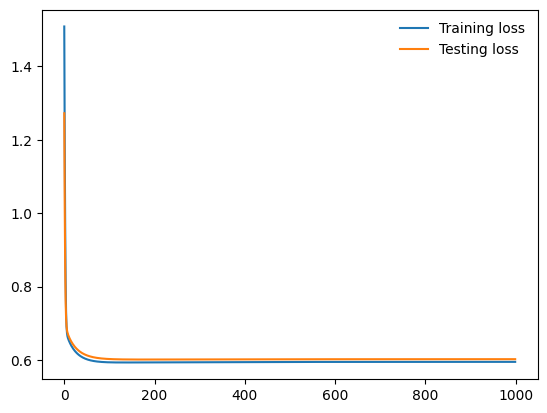

In [9]:
# Plot the losses
lr_methods.display_losses(training=train_losses, testing=test_losses)

Display `training`, `validation` and `test` accuracies

In [10]:
X_test, y_test = df_test.drop(columns=["label"]), df_test["label"]

lr_methods.evaluate(type='Training', model=model, X=X_train, y=y_train)
lr_methods.evaluate(type='Validation', model=model, X=X_val, y=y_val)
lr_methods.evaluate(type='Test', model=model, X=X_test, y=y_test)

Training accuracy: 69.97%
Validation accuracy: 69.58%
Test accuracy: 70.16%


### Hyperparameters tuning - Cross-validation

Let us first define some initial hyperparameters:

In [11]:
criterion = nn.BCEWithLogitsLoss
optimizer = torch.optim.SGD
learning_rate = 0.01
weight_decay = 0.5
epochs = 100

In the following step, we use the [skorch](https://skorch.readthedocs.io/en/stable/) library to wrap the PyTorch model into a scikit-learn compatible model. This allows us to use the scikit-learn tools for hyperparameters tuning.

We first define a `skorch` wrapper for our model:

In [12]:
skorch_net: NeuralNetClassifier = NeuralNetClassifier(
    module=LogisticRegression,
    module__input_dim=8,
    module__nb_classes=1,
    criterion=criterion,
    optimizer=optimizer,
    optimizer__lr=learning_rate,
    optimizer__weight_decay=weight_decay,
    max_epochs=epochs
)

The different steps of the cross-validation here are the following:
* We create a dictionary of hyperparameters to tune. For each hyperparameter, we define a list of values to try.

* We create a `GridSearchCV` object, which will try all possible combinations of hyperparameters when fitting.

* We convert the training data to `torch` tensors.

* We fit the `GridSearchCV` object on the training set. This will train a model for each combination of hyperparameters, and keep the best one.

In [13]:
# Prevent skorch logs from being printed
skorch_net.set_params(train_split=False, verbose=0)

# Define the parameters to be tested in the grid search
params: dict[str, list[float]] = {
    'optimizer__lr': [0.01, 0.005, 0.001],
    'optimizer__weight_decay': [1.0, 0.7, 0.5]
}

# Instantiate the grid search (scikit-learn) object
grid_search = GridSearchCV(skorch_net, params, refit=False, cv=2, scoring='accuracy', verbose=3, error_score='raise')

# Convert the training data to tensors
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float().unsqueeze(1)

# Perform the grid search on the training data through the fitting method of the skorch model.
history = grid_search.fit(X_train_tensor, y_train_tensor)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END optimizer__lr=0.01, optimizer__weight_decay=1.0;, score=0.695 total time=   3.4s
[CV 2/2] END optimizer__lr=0.01, optimizer__weight_decay=1.0;, score=0.532 total time=   3.2s
[CV 1/2] END optimizer__lr=0.01, optimizer__weight_decay=0.7;, score=0.695 total time=   3.3s
[CV 2/2] END optimizer__lr=0.01, optimizer__weight_decay=0.7;, score=0.541 total time=   3.3s
[CV 1/2] END optimizer__lr=0.01, optimizer__weight_decay=0.5;, score=0.696 total time=   3.6s
[CV 2/2] END optimizer__lr=0.01, optimizer__weight_decay=0.5;, score=0.549 total time=   3.4s
[CV 1/2] END optimizer__lr=0.005, optimizer__weight_decay=1.0;, score=0.695 total time=   3.3s
[CV 2/2] END optimizer__lr=0.005, optimizer__weight_decay=1.0;, score=0.610 total time=   3.3s
[CV 1/2] END optimizer__lr=0.005, optimizer__weight_decay=0.7;, score=0.695 total time=   3.3s
[CV 2/2] END optimizer__lr=0.005, optimizer__weight_decay=0.7;, score=0.617 total time=   3

We can now retrieve the best score and hyperparameters.

In [14]:
print("Best score: {:.3f}".format(history.best_score_))
print("Best parameters: {}".format(history.best_params_))

Best score: 0.697
Best parameters: {'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.5}


* **(1 point)** Look at the weights of your classifier. Which features seems to play most for both classes?

In [15]:
# Print the 2 biggest weights of the features for both classes.
print(model.linear.weight[0])

print("\nPositive class\n")
print(model.linear.weight[0].topk(2))


print("\nNegative class\n")
print(model.linear.weight[0].topk(2, largest=False))

tensor([-0.0340, -0.0496, -0.0079, -0.0070, -0.0229,  0.1296, -0.1532,  0.0086],
       grad_fn=<SelectBackward0>)

Positive class

torch.return_types.topk(
values=tensor([0.1296, 0.0086], grad_fn=<TopkBackward0>),
indices=tensor([5, 7]))

Negative class

torch.return_types.topk(
values=tensor([-0.1532, -0.0496], grad_fn=<TopkBackward0>),
indices=tensor([6, 1]))


For the positive class, the number of positive words and the presence of exclamation marks are the most important features.

For the negative class, the number of negative words and the number of first person pronouns are the most important features.

* **\[Bonus\]** The parameter `weight_decay` of the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) corresponds to the L2 penalty. Try playing with this value and explain how it influence the model's weights.

The **weight_decay** parameter adds a L2 penalty (also known as ridge regularization) to the cost. It can reduce the impact of large coefficients and encourage the model to have smaller and more balanced coefficients, which can lead to better generalization performance and prevent overfitting.

The strength of the L2 penalty is controlled by the lambda hyperparameter. Increasing the value of lambda increases the strength of the penalty and results in smaller coefficients, which can reduce overfitting but may also reduce the model's ability to capture complex relationships in the data.

However, it is important to choose an appropriate value of lambda that balances the trade-off between bias and variance, as a too strong penalty can lead to underfitting and a too weak penalty can lead to overfitting.

* **(1 point)** Take two wrongly classified samples in the test set and try explaining why the model was wrong.

In [16]:
df_test_copy = df_test.copy()

df_test_copy["prediction"] = model(torch.tensor(X_test.values).float()).detach().numpy()
df_test_copy["prediction"] = df_test_copy["prediction"].apply(lambda x: 1 if x > 0.5 else 0)
df_test_copy["wrongly_classified"] = df_test_copy["prediction"] != df_test_copy["label"]
df_test_copy[df_test_copy["wrongly_classified"]]

,no,first_pronouns,second_pronouns,exclamation,log_word_count,positive,negative,label,third_person,prediction,wrongly_classified
4,0,2,2,1,4.897840,12,2,0,4,1,True
6,1,2,3,0,5.655992,19,11,0,5,1,True
11,0,6,0,0,5.247024,11,3,0,6,1,True
46,1,7,2,1,5.752573,15,4,0,6,1,True
63,0,0,0,0,4.304065,6,1,0,7,1,True
...,...,...,...,...,...,...,...,...,...,...,...
24993,0,1,1,1,4.897840,6,4,1,1,0,True
24996,0,4,2,1,4.727388,7,3,1,1,0,True
24997,0,2,0,0,5.356586,11,5,1,4,0,True
24998,1,7,2,1,5.929589,13,12,1,5,0,True


#### First wrongly classified sample

In [17]:
# First wrong prediction
df_test_copy[df_test_copy["wrongly_classified"]].head(1)


,no,first_pronouns,second_pronouns,exclamation,log_word_count,positive,negative,label,third_person,prediction,wrongly_classified
4,0,2,2,1,4.89784,12,2,0,4,1,True


The model predicted a positive label, but the true label is negative.

We can see that the number of positive words is higher than the number of negative words.

Also the presence of exclamation marks is a strong indicator of a positive label, as we saw in the previous part.


#### Second wrongly classified sample

In [18]:
# Second wrong prediction
df_test_copy[df_test_copy["wrongly_classified"]][-2:-1]

,no,first_pronouns,second_pronouns,exclamation,log_word_count,positive,negative,label,third_person,prediction,wrongly_classified
24998,1,7,2,1,5.929589,13,12,1,5,0,True


This time, the model predicted a negative label, but the true label is positive. 

The number of positive words is higher than the negative one. But as we can see, the presence of a no in the sentence may influence our model.

The number of first pronouns is high, we saw that it could be a factor of influence for negative class.



* **\[Bonus\]** Train logistic regression classifier using the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). How does it compare with the PyTorch version?


#### Training

In [19]:
# Add a L2 penalty to the logistic regression classifier
model: SKLogisticRegression = scikit_learn_lr.model(penalty='l2', C=0.001)

# Train the model on the training set
sk_training_duration = scikit_learn_lr.fit(model, X_train, y_train)

Training time: 0.08 seconds


#### Evaluation

In [20]:
# Evaluate the model on the training set
_ = scikit_learn_lr.evaluate(model, X_train, y_train, type="Training")

# Evaluate the model on the validation set
scikit_learn_lr.evaluate(model, X_val, y_val, type="Validation")

# Split the test_df into X_test and y_test
_ = X_test = df_test.drop(columns=["label"])
_ = y_test = df_test["label"]

# Evaluate the model on the test set
_ = scikit_learn_lr.evaluate(model, X_test, y_test, type="Test")

Training accuracy: 69.91%
Validation accuracy: 69.68%
Test accuracy: 70.19%


The accuracy of the sklearn logistic regression classifier is comparable to the accuracy of the PyTorch model, as both models have an accuracy approximately the same accuracy on all three datasets.

In [22]:
# Compare the training duration of the PyTorch and Scikit-Learn models as ratio
ratio: float = torch_training_duration / sk_training_duration
print(f"The scikit-learn model performed {ratio:.2f} times faster than the PyTorch model.")

The scikit-learn model performed 15.15 times faster than the PyTorch model.


An interesting observation is that the sklearn model has a much shorter training duration shorter than the PyTorch model, which can be an important factor when training a model on a large dataset.
